### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import glob
import time
import copy
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
import ta
# import tsfresh
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
init_notebook_mode(connected=True)

##### Local

In [6]:
sys.path.append(os.path.dirname(os.getcwd()))

In [7]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Indicators, _Indicators, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest , SingleAssetEnv

##### Functions

In [8]:
def get_weights(size, method='linear', *args):
    if method in ['linear', 'lin']:
        return np.arange(1, size+1)
    elif method in ['exponential', 'exp']:
        a, b = args
        return a**np.linspace(0, b, size)
    return np.ones(size)

### Initialization

In [9]:
cred = Cred()

In [10]:
# bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'AAVE', 'ATOM', 'EOS', 'AVAX', 'XEM', 'XTZ', 'BTT', 'NEO', 'ALGO', 'CHZ', 'DASH', 'SNX', 'MKR', 'COMP', 'BAT', 'ZEC', 'ETC', 'UMA', 'WAVES', 'YFI', 'ZRX', 'ONT', 'REN', 'DGB', 'OMG', 'QTUM', 'LSK', 'OCEAN', 'KNC', 'REP', 'BAND', 'KMD', 'ANT', 'DOGE', 'ENJ', 'LTO', 'THETA']
bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'SOL', 'EGLD']
quotes_or_assets = [_+'USDT' for _ in bases]
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_indicators = None
store_signals = None
raw_signals = False

In [11]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path,
                store_indicators=store_indicators, store_signals=store_signals, raw_signals=raw_signals)

In [12]:
kline = klmngr['SOLUSDT']

### TS libraries tests

In [14]:
dttms = pd.date_range('2021-11-14 15:00:00', '2021-12-20 09:00:00', freq='H')

In [15]:
y = kline.close.loc[dttms].values
x = np.arange(y.size).astype(float)

In [260]:
lags = 20
dar_kwargs = {'size_hidden_layers': 32, 'n_hidden_layers': 2, 'dropout': .0}
deepplf = DeepPLF(lags=lags, horizon=1, breaks=10, forecast_resid='dense', dar_kwargs=dar_kwargs, lam=.0)
deepplf.fit(x, y, epochs=20000) # batch_size=None

DenseAutoregressiveForecasting: 100%|██████████| 20000/20000 [00:22<00:00, 898.35it/s]


In [261]:
pred = deepplf.predict(x, y, ).detach().numpy().flatten()
trend = deepplf.predict(x, y, mod='trend').detach().numpy().flatten()
resid = deepplf.predict(x, y, mod='resid').detach().numpy().flatten()

In [262]:
test_window = 100

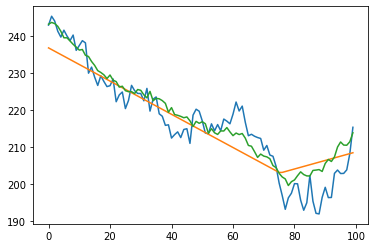

In [263]:
plt.plot(y[lags:lags+test_window])
plt.plot(trend[:test_window])
plt.plot(pred[:test_window])

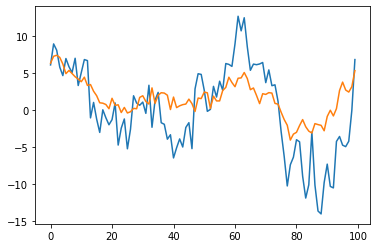

In [264]:
plt.plot(y[lags:lags+test_window] - trend[:test_window])
plt.plot(resid[:test_window])

In [18]:
import winsound

In [544]:
train_size = 100
lags = 100
horizon = 10
sections = 30
epochs = 5000
preds = []
for i in range(sections):
    deepplf = DeepPLF(lags=30, horizon=horizon, breaks=25, forecast_resid='simple', lam=.9)
    index_diff = i*horizon
    x_train = x[index_diff: train_size+index_diff]
    y_train = y[index_diff: train_size+index_diff]
    deepplf.fit(x_train, y_train, epochs=epochs)
    x_test = x[index_diff: train_size+index_diff]
    y_test = y[index_diff: train_size+index_diff]
    pred = deepplf.predict(x_test, y_test)
    pred = pred[-horizon:]
    preds.extend(pred.detach().numpy().tolist()[0])
winsound.Beep(250, 1000)

AutoregressiveForecasting: 100%|██████████| 5000/5000 [00:01<00:00, 2741.05it/s]


(180.0, 220.0)

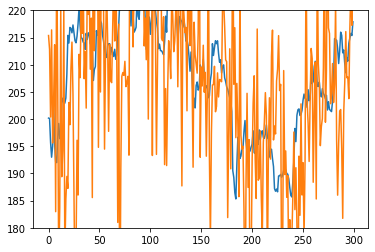

In [545]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)
plt.ylim(180, 220)

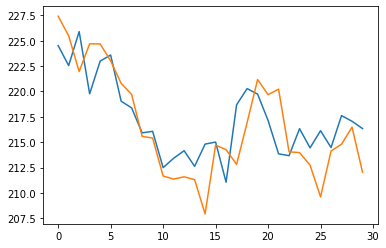

In [518]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)


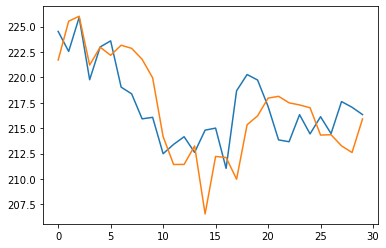

In [516]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)


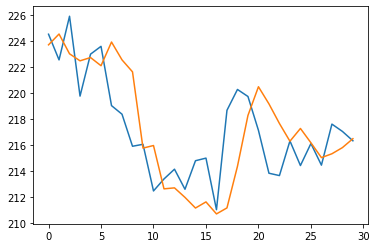

In [514]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)


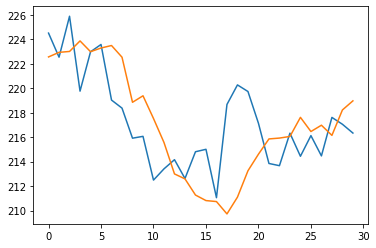

In [507]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)


(180.0, 220.0)

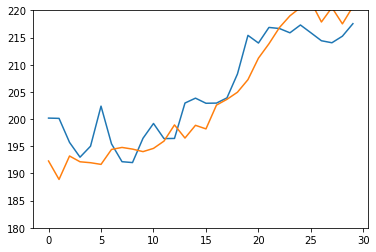

In [486]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)
plt.ylim([180, 220])

(180.0, 220.0)

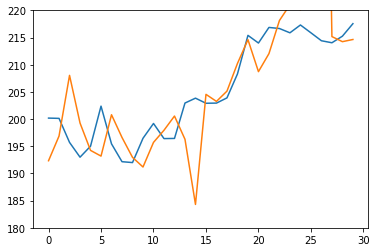

In [482]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)
plt.ylim([180, 220])

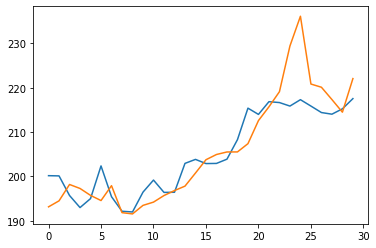

In [479]:
plt.plot(y[train_size: train_size + sections * horizon])
plt.plot(preds)

PiecewiseLinearRegression: 100%|██████████| 5000/5000 [00:03<00:00, 1268.23it/s]


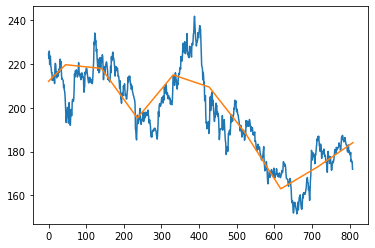

In [412]:
deepplf = DeepPLF(lags=50, horizon=1, breaks=10, forecast_resid=False, lam=.1,)
deepplf.fit(x, y, epochs=5000) # batch_size=None
plt.plot(y[50:])
plt.plot(deepplf.predict(x, y).detach().numpy().flatten())

In [605]:
tensor = torch.tensor(np.arange(1, 11), dtype=torch.float)
tensors = torch.vstack([tensor, tensor+10, tensor+110])

In [606]:
ar = AutoregressiveForecasting(lags=10, outputs=1)
dar = DenseAutoregressiveForecasting(lags=10, outputs=1, n_hidden_layers=2, size_hidden_layers=32)

In [607]:
plf = PiecewiseLinearForecasting(3, 10)

In [608]:
plf(tensors)

tensor([[  2.6390,   2.8352,   3.0314],
        [  5.6747,   6.1551,   6.6355],
        [113.4171, 114.7904, 116.1638]], grad_fn=<SliceBackward>)

In [959]:
class ARPLF(torch.nn.Module):
    
    def __init__(self, breaks, p=1):
        super().__init__()
        self.p = p
        breaks = torch.zeros((1, breaks)) if isinstance(breaks, int) else torch.tensor([breaks], dtype=torch.float)
        self.breaks = torch.nn.Parameter(breaks)
        self.piecewise = torch.nn.Linear(self.breaks.size(1)+1, 1)
        self.autoregressive = torch.nn.Linear(p, 1)

    def forward(self, x, y=None, verbose=False):
        if self.breaks.eq(0).all():
            self.breaks = torch.nn.Parameter(torch.linspace(x.min(), x.max(), self.breaks.size(1), out=self.breaks))
        piecewise = self.piecewise(torch.cat([x, torch.nn.ReLU()(x - self.breaks)], 2))
        ar = [0]
        if y is not None:
            piecewise_residual = torch.nn.LeakyReLU()(y - piecewise)
            ar = self.autoregressive(piecewise_residual[:, -self.p-1:-1, :].reshape(1, -1, self.p))
        return piecewise[:, -1] + ar[0]

In [784]:
plr = PiecewiseLinearRegression(10)
optimizer = torch.optim.Adam(plr.parameters(), lr=0.1)

In [785]:
x_torch = torch.tensor(x, dtype=torch.float)[:, None, None]
y_torch = torch.tensor(y, dtype=torch.float)[:, None, None]

In [786]:
for _ in tqdm(range(10000)):
    p = plr(x_torch)
#     p = plf(x_torch, y_torch)
    optimizer.zero_grad()
#     loss_func(y_torch, p).backward()
    loss = torch.nn.MSELoss()(y_torch, p) # [0]
    if lamda:
        for w in plf.parameters():
            if w.dim() > 1:
                loss = loss + lamda * w.norm(1)
    loss.backward()
    optimizer.step()

100%|██████████| 10000/10000 [00:05<00:00, 1840.80it/s]


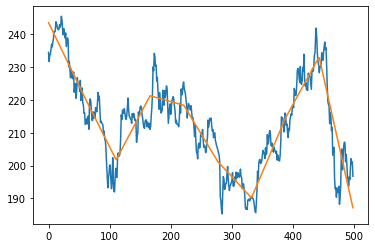

In [787]:
yhat = plr(x_torch).detach().numpy().flatten()
plt.plot(y_torch.flatten())
plt.plot(yhat)

In [788]:
plr_state_dict = plr.state_dict()

In [790]:
breaks = 10
plr = plr.eval() # breaks
history = 50
horizon = 1
lamda = .0
x_torch = torch.tensor([x[i: i+history] for i in range(0, len(x)-history+1)], dtype=torch.float)
y_torch = torch.tensor([y[i+history: i+history+horizon] for i in range(0, len(x_torch)-horizon)], dtype=torch.float)
x_torch = x_torch[: len(y_torch)]
# plf = PiecewiseLinearForecasting(breaks=[100, 150, 200, 250, 300, 350, 400, 450, 500], p=5)
plf = PiecewiseLinearForecasting(horizon=horizon, plr=plr)
plf(x_torch);
optimizer = torch.optim.Adam(plf.parameters(), lr=0.1)
# loss_func = torch.nn.functional.mse_loss

In [791]:
for _ in tqdm(range(1000)):
    p = plf(x_torch)
#     p = plf(x_torch, y_torch)
    optimizer.zero_grad()
#     loss_func(y_torch, p).backward()
    loss = torch.nn.MSELoss()(y_torch, p) # [0]
    if lamda:
        for w in plf.parameters():
            if w.dim() > 1:
                loss = loss + lamda * w.norm(1)
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:01<00:00, 533.12it/s]


In [792]:
plf_state_dict = plf.state_dict()

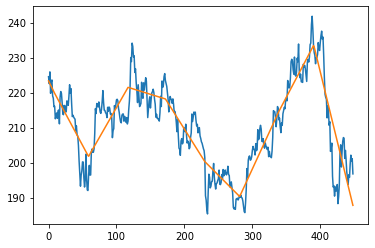

In [793]:
yhat = plf(x_torch).detach().numpy()
plt.plot(y_torch)
plt.plot(yhat)

In [794]:
plr_state_dict

OrderedDict([('breaks',
              tensor([[  0.6293,  57.3245, 108.8394, 167.0460, 222.1444, 279.5103, 331.3254,
                       388.4910, 440.3589, 498.0000]])),
             ('piecewise.weight',
              tensor([[-0.2690, -0.1321,  0.0390,  0.7015, -0.3999, -0.2498,  0.1156,  0.6167,
                       -0.0533, -1.1631,  0.0406]])),
             ('piecewise.bias', tensor([243.2805]))])

In [795]:
plf_state_dict

OrderedDict([('plr.breaks',
              tensor([[  0.6293,  57.3245, 108.8394, 167.0460, 222.1444, 279.5103, 331.3254,
                       388.4910, 440.3589, 498.0000]])),
             ('plr.piecewise.weight',
              tensor([[-0.2690, -0.1321,  0.0390,  0.7015, -0.3999, -0.2498,  0.1156,  0.6167,
                       -0.0533, -1.1631,  0.0406]])),
             ('plr.piecewise.bias', tensor([243.2805]))])

In [117]:
results = []
x_torch_all = torch.tensor([x[i: i+size] for i in range(0, len(x)-size+1)], dtype=torch.float)[:, :, None]
y_torch_all = torch.tensor([y[i: i+size] for i in range(0, len(y)-size+1)], dtype=torch.float)[:, :, None]
for i in tqdm(range(x_torch_all.shape[0])):
    x_torch = x_torch_all[[i]]
    y_torch = y_torch_all[[i]]
    for _ in range(500):
        p = plf(x_torch)
#         p = plf(x_torch, y_torch)
        optimizer.zero_grad()
        # loss_func(y_torch, p).backward()
        loss = torch.nn.MSELoss()(y_torch[:, -1], p) # [0]
        if lamda:
            for w in plf.parameters():
                if w.dim() > 1:
                    loss = loss + lamda * w.norm(1)
        loss.backward()
        optimizer.step()
    results.append(plf(x_torch).detach().numpy()[0][0])
#     results.append(plf(x_torch, y_torch).detach().numpy()[0][0])

100%|██████████| 400/400 [06:02<00:00,  1.10it/s]


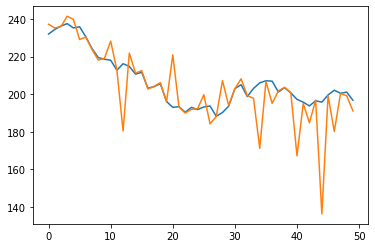

In [113]:
plt.plot(y[size:][-50:])
plt.plot(results[-50:])

In [1459]:
x_torch = torch.tensor([x[i: i+size] for i in range(0, len(x)-size+1)], dtype=torch.float)[:, :, None]
y_torch = torch.tensor([y[i: i+size] for i in range(0, len(y)-size+1)], dtype=torch.float)[:, :, None]
for _ in tqdm(range(1000)):
#     p = plf(x_torch)
    p = plf(x_torch, y_torch)
    optimizer.zero_grad()
#     loss_func(y_torch, p).backward()
    loss = torch.nn.MSELoss()(y_torch[:, -1], p) # [0]
    if lamda:
        for w in plf.parameters():
            if w.dim() > 1:
                loss = loss + lamda * w.norm(1)
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:06<00:00, 156.29it/s]


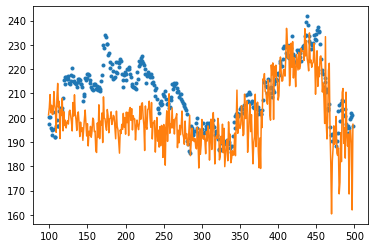

In [1390]:
p = plf(x_torch, y_torch).detach().numpy()
plt.plot(x_torch[:, -1, 0], y[size-1:], ".")
plt.plot(x_torch[:, -1, 0], p)

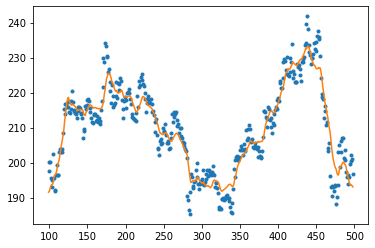

In [56]:
p = plf(x_torch, y_torch).detach().numpy()
plt.plot(x_torch[:, -1, 0], y[size-1:], ".")
plt.plot(x_torch[:, -1, 0], p)

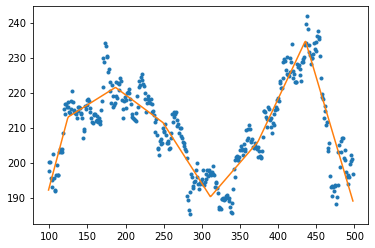

In [25]:
p = plf(x_torch,).detach().numpy()
plt.plot(x_torch[:, -1, 0], y[size-1:], ".")
plt.plot(x_torch[:, -1, 0], p)

In [1486]:
# x_torch = torch.tensor([x], dtype=torch.float)[:, :, None]
# y_torch = torch.tensor([y], dtype=torch.float)[:, :, None]
x_torch = torch.tensor([x[i: i+size] for i in range(0, len(x)-size+1)], dtype=torch.float)[:, :, None]
y_torch = torch.tensor([y[i: i+size] for i in range(0, len(y)-size+1)], dtype=torch.float)[:, :, None]
for _ in tqdm(range(1000)):
#     p = plf(x_torch)
    p = plf(x_torch, y_torch, return_sequence=True)
    optimizer.zero_grad()
#     loss_func(y_torch, p).backward()
    loss = torch.nn.MSELoss()(y_torch, p) # [0]
    if lamda:
        for w in plf.parameters():
            if w.dim() > 1:
                loss = loss + lamda * w.norm(1)
    loss.backward()
    optimizer.step()

100%|██████████| 1000/1000 [00:06<00:00, 155.50it/s]


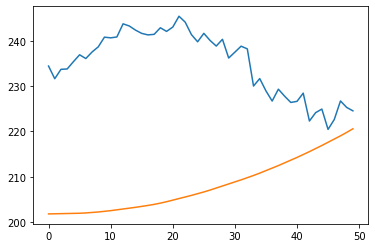

In [1490]:
plt.plot(x[:size], y[:size])
plt.plot(plf(x_torch, y_torch, return_sequence=True)[0].detach().numpy())

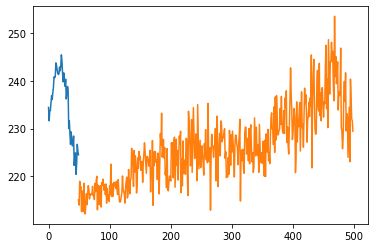

In [1484]:
plt.plot(x[:size], y[:size])
plt.plot(x[size-1:], plf(x_torch, y_torch).detach().numpy())

In [308]:
plf.state_dict()

OrderedDict([('breaks',
              tensor([[  0.0000,  62.3750, 124.7500, 187.1250, 249.5000, 311.8750, 374.2500,
                       436.6250, 499.0000]])),
             ('piecewise.weight',
              tensor([[-1.7391e-01, -5.2693e-01,  1.6420e+00,  6.7156e-01,  2.8104e-01,
                        1.4234e-01, -3.8217e-01, -2.0941e-01,  8.1204e-01,  6.2746e-04]])),
             ('piecewise.bias', tensor([-10.2942])),
             ('autoregressive.weight',
              tensor([[-1.0204e+00, -4.4520e-01, -3.0278e-01, -5.6417e-03,  1.2335e-01,
                        2.4259e-01,  3.1946e-01,  2.8156e-01,  2.9099e-01, -4.4691e-04,
                       -3.1074e-03,  1.5882e-02,  7.8153e-02, -6.5530e-02,  1.7727e-01,
                        1.6789e-01,  3.0862e-01,  3.7364e-01,  7.4229e-01,  9.4285e-01]])),
             ('autoregressive.bias', tensor([-59.9901]))])

In [929]:
plf = PiecewiseLinearForecasting(n_breaks=20, p=5)
optimizer = torch.optim.Adam(plf.parameters(), lr=0.1)
# loss_func = torch.nn.functional.mse_loss
lam = .0

In [734]:
x_torch = torch.tensor([x], dtype=torch.float)[:, :, None]#[:,None]
y_torch = torch.tensor([y], dtype=torch.float)[:, :, None]#[:,None]
for _ in range(10000):
    p = plf(x_torch)
    optimizer.zero_grad()
#     loss_func(y_torch, p).backward()
    loss = torch.nn.MSELoss()(y_torch, p)
    if lam:
        for w in plf.parameters():
            if w.dim() > 1:
                loss = loss + lam * w.norm(1)
    loss.backward()
    optimizer.step()

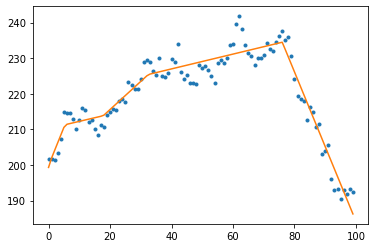

In [746]:
x_grid = np.arange(0, 100, 1)
p = plf(torch.tensor([x_grid], dtype=torch.float)[:, :, None]).detach().numpy()[0]
plt.plot(x, y, ".")
plt.plot(x_grid, p)
plt.show()

In [18]:
plm = PiecewiseLinearRegression(n_breaks=20)
optimizer = torch.optim.Adam(plm.parameters(), lr=0.1)
# loss_func = torch.nn.functional.mse_loss
lam = .0

In [37]:
x_torch = torch.tensor(x[100:], dtype=torch.float)[:,None]
y_torch = torch.tensor(y[100:], dtype=torch.float)[:,None]
for _ in range(50000):
    p = plm(x_torch)
    optimizer.zero_grad()
#     loss_func(y_torch, p).backward()
    loss = torch.nn.MSELoss()(y_torch, p)
    if lam:
        for w in plm.parameters():
            if w.dim() > 1:
                loss = loss + lam * w.norm(1)
    loss.backward()
    optimizer.step()

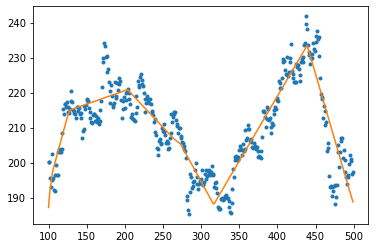

In [38]:
x_grid = np.arange(0, 100, 1)
p = plm(x_torch) #plm(torch.tensor(x, dtype=torch.float)[:,None])
p = p.flatten().detach().numpy()
plt.plot(x_torch, y[100:], ".")
plt.plot(x_torch, p)
plt.show()

Darts

In [12]:
from darts import TimeSeries
from darts.models import *

from darts.metrics import mape, mase
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist

In [25]:
all_assets = klmngr.assets
sel_assets = ['ETHUSDT']
rem_assets = [_ for _ in all_assets if _ not in sel_assets]

In [35]:
series_df = pd.concat([klmngr[_].daily[['close']] for _ in sel_assets], axis=1).reset_index()
series = TimeSeries.from_dataframe(series_df, time_col='index')

In [ ]:
# other assets as covariates
covariates_df = pd.concat([klmngr[_].daily['close'].rename(_) for _ in rem_assets], axis=1)
covariates_df = covariates_df.fillna(covariates_df.mean())
covariates_df = covariates_df.reset_index()
covariates = TimeSeries.from_dataframe(covariates_df, time_col='index')

In [216]:
# signals as covariates
covariates_df = pd.concat([klmngr[_].daily.signals.pipe(lambda df: df.rename(columns=df.columns.to_series()+f'_{_}')) for _ in assets])
covariates_df = covariates_df.fillna(covariates_df.mean())
covariates_df = covariates_df.reset_index()
covariates = TimeSeries.from_dataframe(covariates_df, time_col='index')

In [218]:
train_perc = .7
time_index_split = series.time_index[int(series.time_index.shape[0]*train_perc)]
train, val = series.split_after(time_index_split)
cov_train, cov_val = covariates.split_after(time_index_split)

In [219]:
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [220]:
cov_transformer = Scaler()
cov_train_transformed = cov_transformer.fit_transform(cov_train)
cov_val_transformed = cov_transformer.transform(cov_val)
covariates_transformed = cov_transformer.transform(covariates)

In [ ]:
model = RNNModel(
    model='GRU',
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0.1,
    batch_size=32,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='eth_lstm',
    log_tensorboard=False,
    random_state=42,
    training_length=90,
    input_chunk_length=30,
    force_reset=True
)

In [ ]:
model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=30,
    output_chunk_length=1,
    hidden_size=20,
    n_rnn_layers=3,
#     hidden_fc_sizes=20,
    dropout=0.1,
    batch_size=32,
    n_epochs=300,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='eth_blocklstm',
    log_tensorboard=False,
    random_state=42,
    force_reset=True
)

In [ ]:
model = TCNModel(
    model_name='eth_tcn',
    input_chunk_length=13,
    output_chunk_length=12, 
    n_epochs=500, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
    force_reset=True,
)

In [ ]:
model = TransformerModel(
    input_chunk_length = 12,
    output_chunk_length = 1,
    batch_size = 32,
    n_epochs = 400,
    model_name = 'eth_transformer',
    log_tensorboard=False,
    nr_epochs_val_period = 10,
    d_model = 32,
    nhead = 16,
    num_encoder_layers = 3,
    num_decoder_layers = 3,
    dim_feedforward = 512,
    dropout = 0.1,
    activation = "relu",
    random_state=42,
    force_reset=True,
)

In [229]:
model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=1,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=2,
    num_layers=4,
    layer_widths=512,
    n_epochs=500,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name='eth_nbeats',
    force_reset=True,
)

In [230]:
model.fit(train_transformed, 
#           past_covariates=cov_train_transformed,
          val_series=val_transformed, 
#           val_past_covariates=cov_val_transformed, 
          verbose=True)

[2021-11-07 13:31:14,484] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1051 samples.
[2021-11-07 13:31:14,484] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 1051 samples.
[2021-11-07 13:31:14,572] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-11-07 13:31:14,572] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/500 [00:00<?, ?it/s]

In [231]:
model_name = 'eth_nbeats'
best_model = model.__class__.load_from_checkpoint(model_name=model_name, best=True)

loading model_best_64.pth.tar


In [ ]:
asset_l = ['ETHUSDT', 'BTCUSDT', 'ADAUSDT']
daily_l = [klmngr[_].daily for _ in asset_l]
daily_closes_l = [_[['close']] for _ in daily_l]
daily_closes_df =  pd.concat(daily_closes_l, axis=1)
daily_closes_df.columns = [asset_l]

In [ ]:
tsdata = TimeSeries.from_dataframe(daily_closes_df)

In [ ]:
covs = klmngr['ETHUSDT'].daily[['open', 'low', 'high', 'volume', 'number_of_trades']].merge(klmngr['BTCUSDT'].daily[['close']], left_index=True, right_index=True).reset_index()
tsdata = TimeSeries.from_dataframe(klmngr['ETHUSDT'].daily['close'].reset_index(), 'index', ['close'])
covariates = TimeSeries.from_dataframe(covs, 'index')

In [ ]:
model = RandomForest(lags=list(range(-5, 0)), lags_past_covariates=list(range(-5, 0)))

In [ ]:
model = Prophet(daily_seasonality=False)

In [ ]:
model = LightGBMModel(lags=list(range(-5, 0)), lags_past_covariates=list(range(-5, 0)))

In [ ]:
model = VARIMA(p=1, d=0, q=1, trend='ct')

In [ ]:
model = NaiveEnsembleModel([
    Prophet(daily_seasonality=False, use_past_covariates=False),
    LightGBMModel(lags=list(range(-10, 0)), lags_past_covariates=list(range(-10, 0)))
])

In [ ]:
tsdata.plot()

In [ ]:
hist = model.historical_forecasts(tsdata, start=tsdata.time_index[-200], past_covariates=covariates, verbose=True)

In [ ]:
hist = model.historical_forecasts(series_transformed, start=series_transformed.time_index[-200], past_covariates=covariates_transformed, verbose=True, retrain=False)

In [235]:
hist = best_model.historical_forecasts(series_transformed, start=series_transformed.time_index[-200], verbose=True, retrain=False)

  0%|          | 0/200 [00:00<?, ?it/s]

295.89539517326193


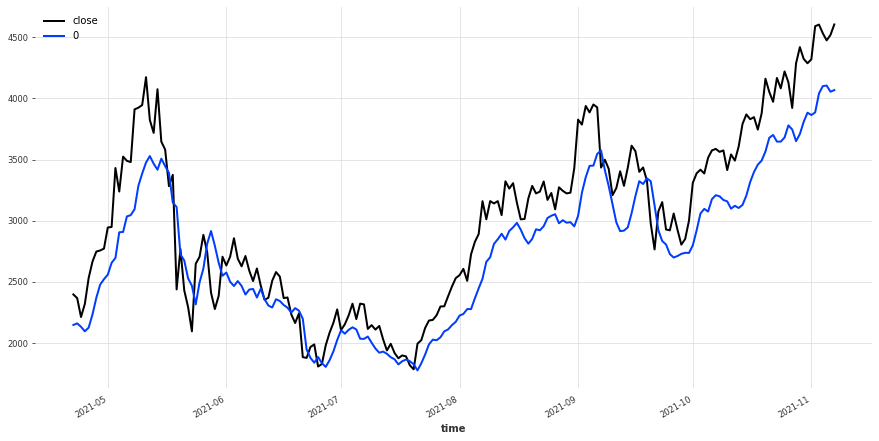

In [236]:
hist_ = transformer.inverse_transform(hist)
print(abs(hist_-series.slice_intersect(hist_)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
series[-200:].plot()
hist_[-200:].plot()

591.0202738205954


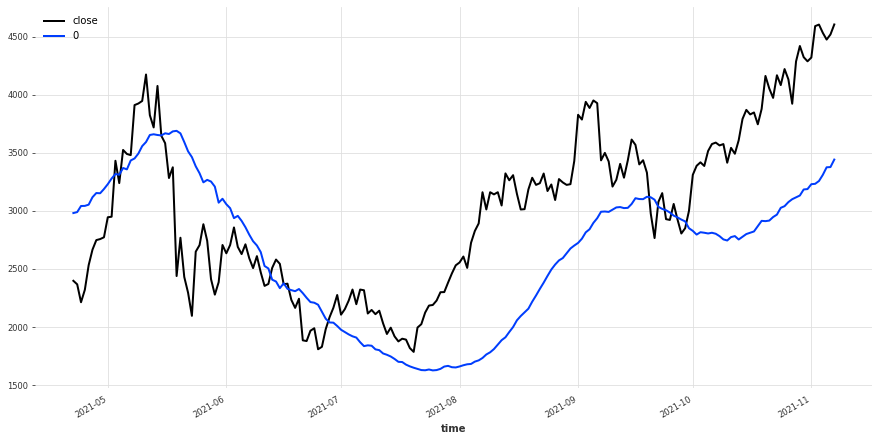

In [153]:
hist_ = transformer.inverse_transform(hist)
print(abs(hist_-series.slice_intersect(hist_)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
series[-200:].plot()
hist_[-200:].plot()

447.5019400938491


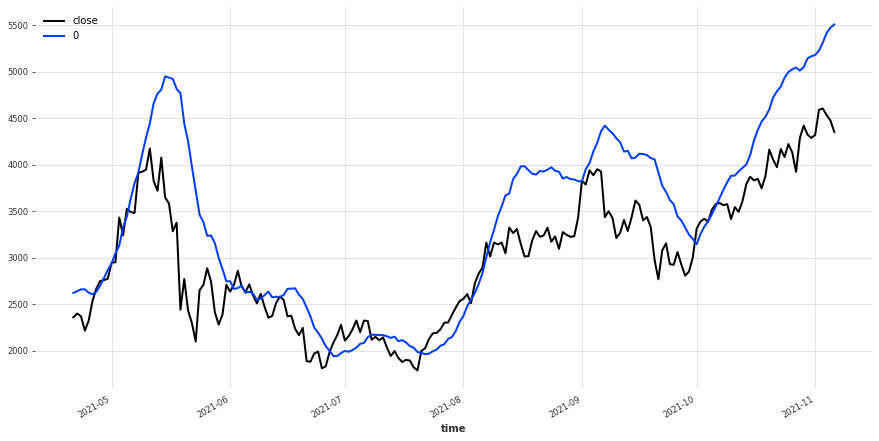

In [134]:
hist_ = transformer.inverse_transform(hist)
print(abs(hist_-series.slice_intersect(hist_)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
series[-200:].plot()
hist_[-200:].plot()

355.127584816929


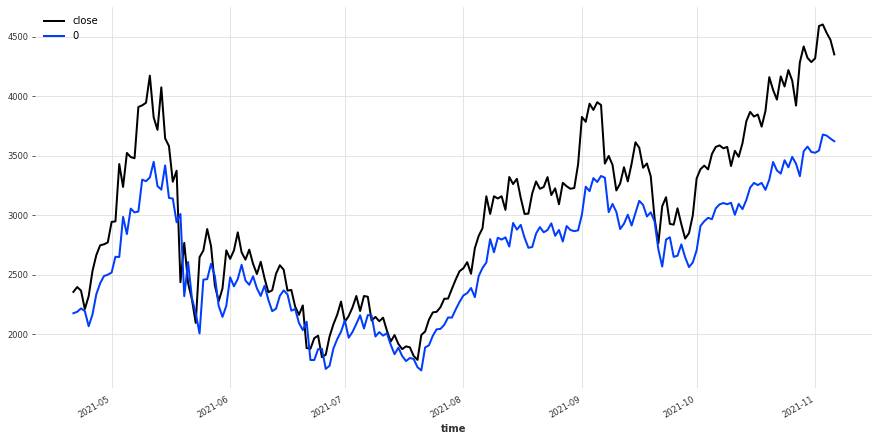

In [101]:
hist_ = transformer.inverse_transform(hist)
print(abs(hist_-series.slice_intersect(hist_)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
series[-200:].plot()
hist_[-200:].plot()

205.25486414104176


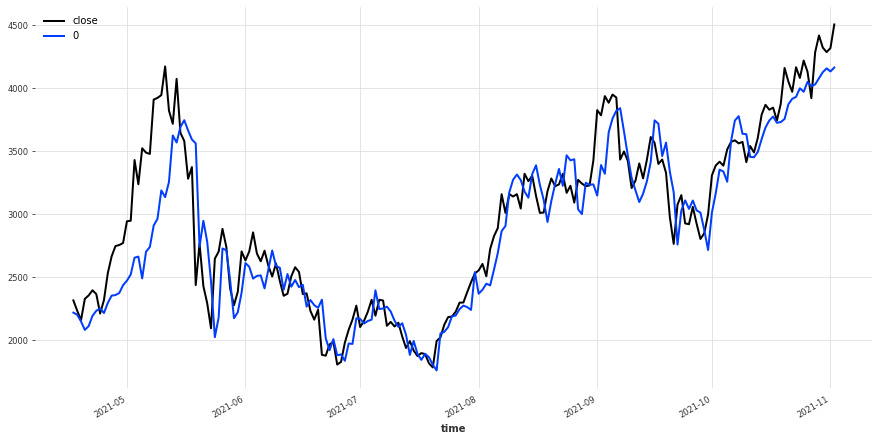

In [82]:
print(abs(hist-tsdata.slice_intersect(hist)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
tsdata[-200:].plot()
hist[-200:].plot()

422.2004641706211


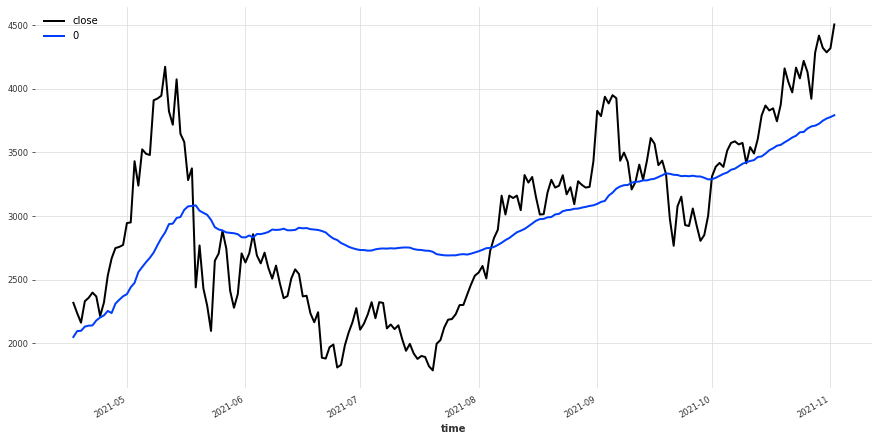

In [79]:
print(abs(hist-tsdata.slice_intersect(hist)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
tsdata[-200:].plot()
hist[-200:].plot()

156.8396769999998


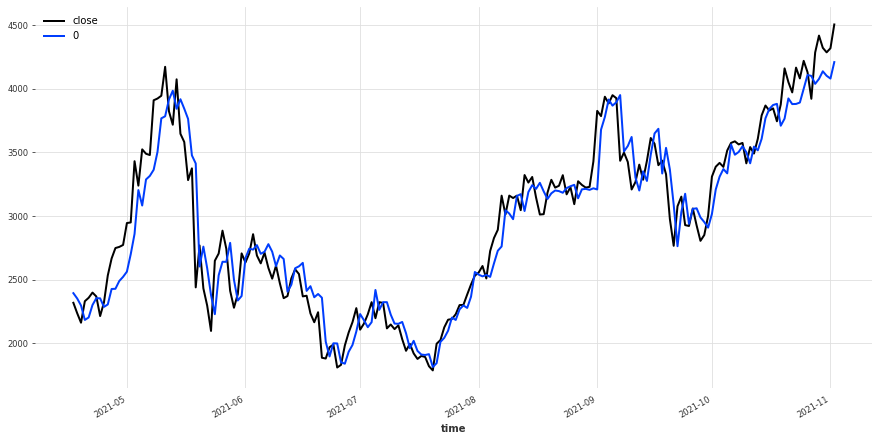

In [77]:
print(abs(hist-tsdata.slice_intersect(hist)).mean()[0])
fig, ax = plt.subplots(figsize=(15, 7))
tsdata[-200:].plot()
hist[-200:].plot()

Kats

In [71]:
from kats.consts import Params, TimeSeriesData
from kats.utils.backtesters import BackTesterExpandingWindow, BackTesterRollingWindow

In [72]:
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.linear_model import LinearModel, LinearModelParams
from kats.models.stlf import STLFModel, STLFParams
from kats.models.lstm import LSTMModel, LSTMParams

In [104]:
from cryptoast.model.model import BackTesterDates

In [105]:
import psutil
multi = psutil.cpu_count(logical=False)-1

In [106]:
data = kline_d[['close']].reset_index().rename(columns={'index': 'time', 'close': 'value'})

In [107]:
ts_data = TimeSeriesData(data)

In [40]:
params = ProphetParams(growth='linear', seasonality_mode='multiplicative')

In [111]:
params = SARIMAParams(1, 1, 1, seasonal_order=(1, 1, 1, 2))

In [117]:
params = LSTMParams(16, 30, 3)

In [128]:
test_dates = ts_data.time.iloc[-200:-10].values
backtest = BackTesterDates(error_methods=['mae'], data=ts_data, test_dates=test_dates, steps_ahead=0, window=None, model_class=LSTMModel, params=params, multi=False)

In [129]:
backtest.run_backtest()

KeyboardInterrupt: 

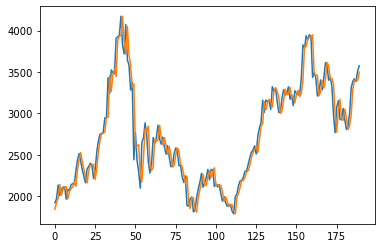

In [61]:
plt.plot(data.set_index('time').loc[test_dates].value.values)
plt.plot([_[3][0] for _ in backtest.results])

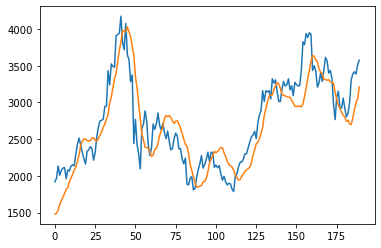

In [47]:
plt.plot(data.set_index('time').loc[test_dates].value.values)
plt.plot([_[3][0] for _ in backtest.results])

In [67]:
pd.Timestamp(test_dates[0])

Timestamp('2021-10-13 23:00:00')

In [68]:
pd.Index(ts_data.time).get_loc(test_dates[0])

36325

In [70]:
backtest._create_train_test_splits()[0][0], backtest._create_train_test_splits()[1][0]

((0, 36325), (36325, 36326))

In [ ]:
res = backtest.run_backtest()

In [40]:
prophet_params = ProphetParams(seasonality_mode='multiplicative')
prophet_m = ProphetModel(ts_data[ts_data.time<pd.Timestamp('20210401')], prophet_params)

In [41]:
prophet_m.fit()

In [48]:
preds = prophet_m.predict(90)

<AxesSubplot:xlabel='time'>

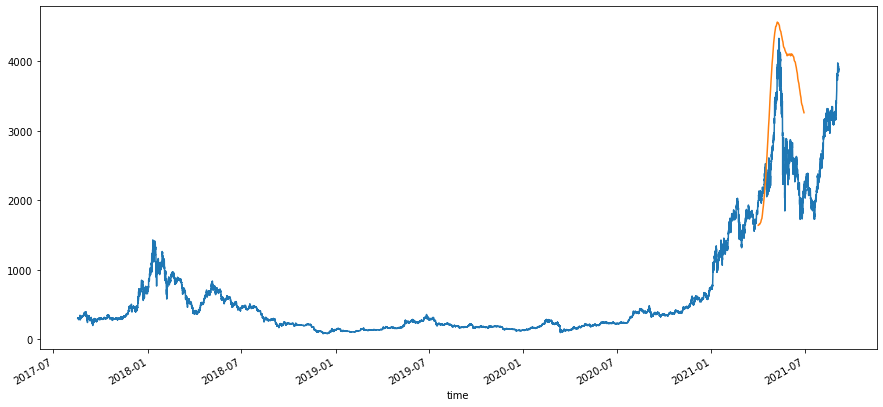

In [68]:
fig, ax = plt.subplots(figsize=(15, 7))
ts_data.to_dataframe().set_index('time').value.plot()
preds.set_index('time').fcst.plot()

### Update

In [13]:
print(datetime.utcnow().replace(microsecond=0))

2021-11-28 16:12:43


In [15]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

Timestamp('2021-11-28 09:00:00')

In [18]:
klmngr.update(verbose=1)

100%|██████████| 15/15 [01:27<00:00,  5.86s/it]


In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

### Preprocessing

##### Artificial USDT

### Baseline

Single asset

In [610]:
kline = klmngr['ETHUSDT']

In [24]:
kline_raw = Kline('ETH', kline, info=kline.info)
kline_raw.signalsjar.set_raw()
kline_binary = Kline('ETH', kline, info=kline.info)
kline_binary.signalsjar.set_raw(False)

In [ ]:
# In below sigs calculations there is NO need to SHIFT values:
#     You take signals info up to current hour close for a .step (which results in an action in the next hour).
#     Thus no future info is used.
#     Start index should be 0 though.

In [25]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
# _sigs = kline.signals.eq(1).mean(axis=1).rolling(6).mean().values[:-1]
#sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))

In [26]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

In [ ]:
btst_ref = copy.deepcopy(btst) # For matching env tests.

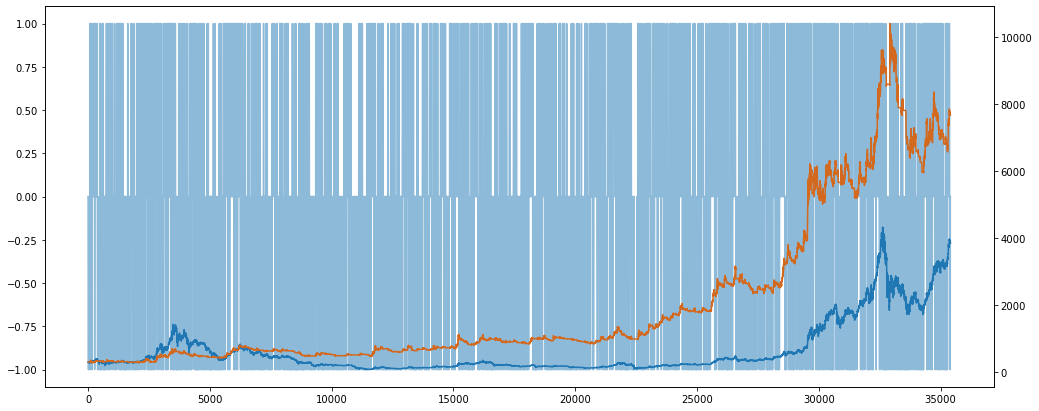

In [27]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

Specific part for future comparison reference

In [28]:
kline_part = kline.loc[np.random.choice(kline.index):].loc['20200101':]

In [29]:
_sigs = kline_part.signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
#sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))

In [30]:
btst_ref = Backtest(kline_part, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst_ref.run(999*sigs, verbose=0)

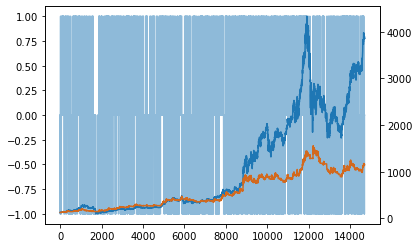

In [31]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst_ref.periodic.value.values, c='chocolate')

Random part of a single asset

In [149]:
kline = klmngr['ETHUSDT']

In [190]:
kline_part = kline.loc[np.random.choice(kline.index):].iloc[:24*30*2]

In [243]:
_sigs = kline_part.signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
#sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))

In [244]:
btst = Backtest(kline_part, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

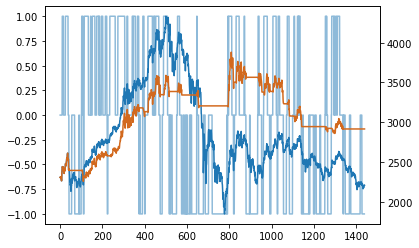

In [23]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

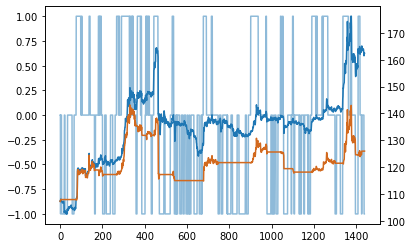

In [83]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

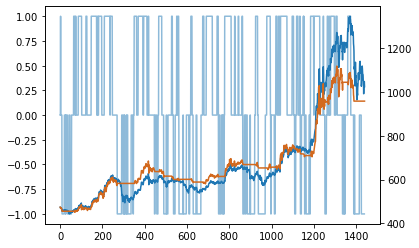

In [79]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

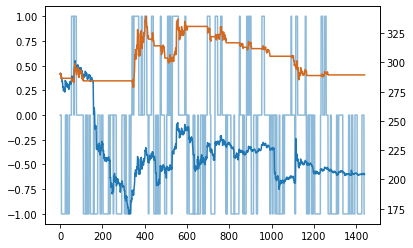

In [75]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

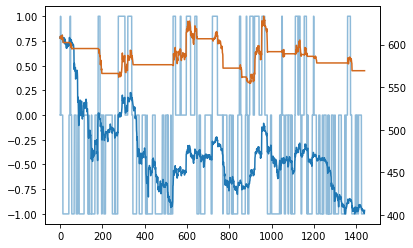

In [71]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

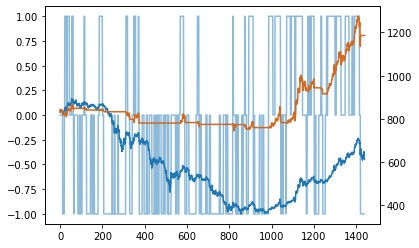

In [67]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

### Model test 2: RF

##### Manual reloads

In [246]:
from cryptoast.model.agents import SingleAssetEnv

In [247]:
from stable_baselines.common.policies import FeedForwardPolicy, ActorCriticPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP

##### Testing ground

- Mathcing SingleAssetEnv results with simple Backtest results: passed

In [250]:
btst = Backtest(kline=klmngr['ETHUSDT'], init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0, memory=6)
env = SingleAssetEnv(klmngr, assets=['ETHUSDT'], backtest=btst, window=3, episode_steps=24*30*12*5, randomize_start=False, allow_gaps=True)

In [397]:
def get_action(obs):
    mean = np.median((obs[:-12].reshape(-1, 3).T==1).mean(1))
    action = 2 if mean >= .55 else (0 if mean < .2 else 1)
    return mean, action

In [398]:
done = False
obs = env.reset()
means = []
while not done:
    try:
        mean, action = get_action(obs)
        obs, reward, done, info = env.step(action)
        means.append(mean)
    except Exception as e:
        print(e)
        pass

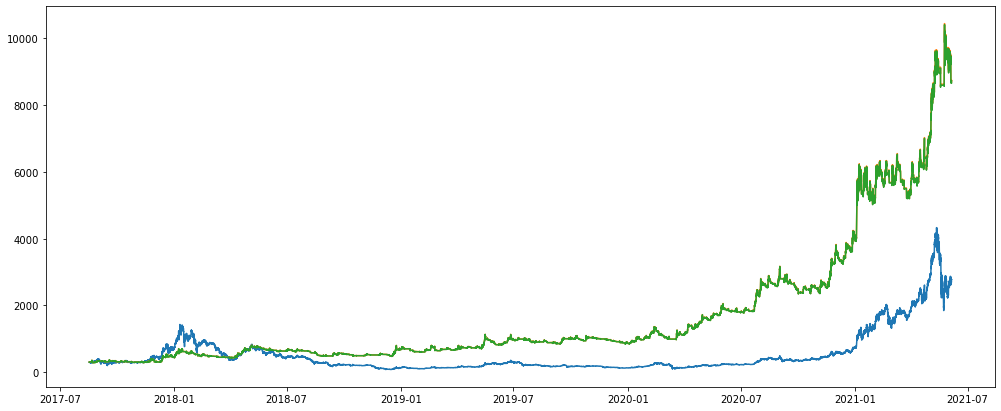

In [399]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(env.kline.loc[btst.periodic.index].close)
ax.plot(btst.periodic.value)
ax.plot(btst_ref.periodic.value)

- Miscellaneous tests: check_env, reward design, ...

In [251]:
# asset = np.random.choice(klmngr.assets)
asset = 'ETHUSDT'
kline = klmngr[asset]
btst = Backtest(kline=kline, init_assets=1, memory=24, commission=0.001, slippage_pct=0.1, slippage_steps=0)
env = SingleAssetEnv(klmngr, assets=[asset], backtest=btst, window=3, episode_steps=24*30*12*5, randomize_start=False, allow_gaps=True)

100


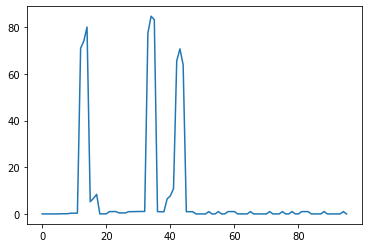

In [252]:
# obs = env.step(np.random.choice([0, 1, 2]))[0]
obs = [env.step(_) for _ in np.random.choice([0, 1, 2], size=100)][-1][0]
print(env.current_step)
plt.plot(obs)

In [253]:
check_env(env)

In [254]:
obs = env.reset()

In [286]:
action = 0

In [274]:
action = 2

{'cash': 314.4430683856801, 'assets': 0.0, 'value': 314.4430683856801}
0.0


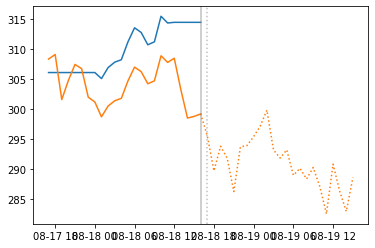

In [291]:
obs, reward, _, __ = env.step(action)
timestamp = env.backtest.position['timestamp']
plt.plot(env.backtest.periodic.value[:timestamp].iloc[-24:], c='C0')
plt.plot(env.kline.close[:timestamp].iloc[-24:], c='C1')
plt.plot(env.kline.close[timestamp:].iloc[:24], c='C1', linestyle=':')
plt.axvline(timestamp, c='grey', alpha=.5)
plt.axvline(timestamp+pd.Timedelta(hours=1), c='grey', alpha=.5, linestyle=':')
action = 1
print(env.backtest._periodic[env.backtest.position['timestamp']])
print(reward)

##### Defining assets

- Check for uniform shape within indicators and define train assets

In [ ]:
bad_assets = [asset for asset in klmngr.assets if klmngr[asset].indicators.columns.size != 34]
print(bad_assets)

- Define pool of train assets

In [ ]:
train_assets = list(set(klmngr.assets)-set(test_assets)-set(bad_assets))

##### RL Training and Testing

- Define

In [272]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [267]:
train_assets = ['ETHUSDT']

In [268]:
test_assets = train_assets

In [297]:
window = 6
memory = 24
episode_steps = 24*30*2
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0.1, slippage_steps=0, memory=memory)
env_kwargs = dict(klmngr=klmngr,
                  assets=train_assets,
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=episode_steps)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [298]:
checkpoint_callback = CheckpointCallback(save_freq=episode_steps*10, save_path='../models/h5/',
                                         name_prefix='checkpoint_model')

eval_callback = EvalCallback(env, 
                             best_model_save_path='../models/h5/',
                             log_path='../models/logs/',
                             n_eval_episodes=5,
                             eval_freq=episode_steps*10,
                             deterministic=True, 
                             render=False)

callback_list = CallbackList([checkpoint_callback, eval_callback])

In [299]:
total_timesteps = 500*1000
tensorboard_log = '../models/logs_tensorboard/' # None
# model = DQN(policy='MlpPolicy', env=env, exploration_fraction=.2, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1, tensorboard_log=tensorboard_log)
# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)

# model = DQN(policy=CustomDQNPolicy, env=env, gamma=.999, prioritized_replay=True, train_freq=episode_steps//10, tensorboard_log=tensorboard_log, verbose=1)
model = PPO2(policy='MlpPolicy', env=env, verbose=1, tensorboard_log=tensorboard_log, gamma=.999)
# model = A2C(policy='MlpPolicy', env=env, verbose=1)

In [ ]:
checkpoint_filepaths = glob.glob('../models/h5/checkpoint*.zip')
checkpoint_max = max([int(_.split('_')[-2]) for _ in checkpoint_filepaths])
load_path = [_ for _ in checkpoint_filepaths if int(_.split('_')[-2]) == checkpoint_max][0]
print(load_path)

In [ ]:
# model.load(load_path='../models/h5/best_model.zip', env=env)
model.load(load_path=load_path, env=env)

In [ ]:
# model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')
model.load_parameters(load_path_or_dict=load_path)

- Train

In [ ]:
# model.learn(total_timesteps)
model.learn(total_timesteps, callback=callback_list)

In [277]:
env_kwargs.update(
    dict(
        assets=test_assets,
#         backtest=btst,
        datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
        randomize_start=False,
        allow_gaps=True,
        episode_steps=-1,
    )
)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [286]:
model.load(load_path='../models/h5/best_model.zip', env=env)

In [287]:
model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')

In [288]:
n_steps = klmngr[test_assets[0]].loc[btst.position['timestamp']:].shape[0]
print(n_steps)

12987


In [280]:
vec_env = not(isinstance(env, SingleAssetEnv))
print(vec_env)

True


In [289]:
obs = env.reset()
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
#     action_proba = model.action_probability(obs)[0]
#     if action_proba[2]/action_proba[[0, 2]].sum() > .55:
#         action = 2
#     else:
#         if action_proba[0]/action_proba[[0, 2]].sum() < .2:
#             action = 0
#         else:
#             action = 1
#     action = np.array([action])
    action, _ = model.predict(obs, deterministic=False)
#     action = [np.random.choice([0, 1, 2], p=model.action_probability(obs)[0])]
    obs, reward, done, info = env.step(action)
    if vec_env:
        reward_list.append(reward[0])
        action_list.append(action[0])
        values_dict = {**values_dict, **info[0]['periodic']}
    else:
        reward_list.append(reward)
        action_list.append(action)
        values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
    # if step%1000==0:
    #     print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", sum(reward_list))
        break

Goal reached! reward= -5.498794615453335


In [290]:
pd.value_counts(action_list)

2    4395
1    4320
0    4270
dtype: int64

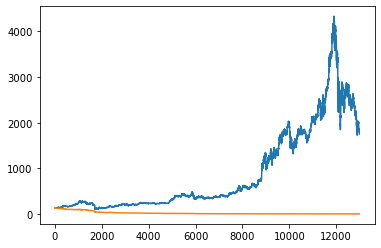

In [291]:
# Test
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

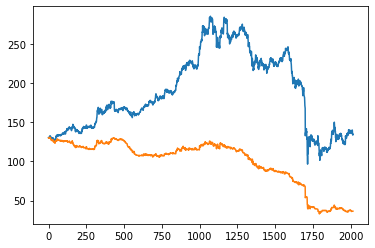

In [312]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

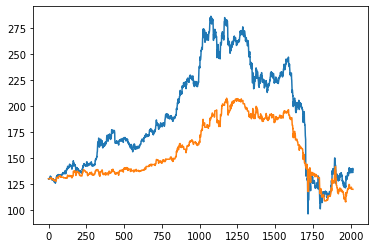

In [102]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

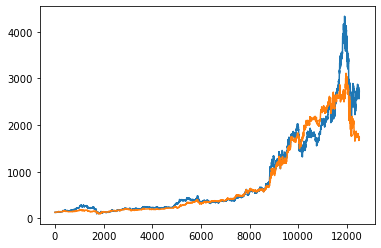

In [40]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

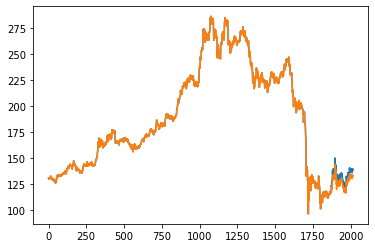

In [122]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

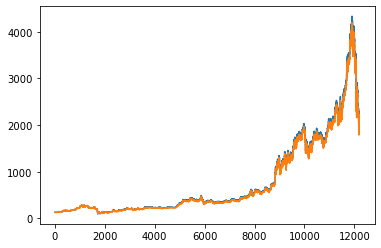

In [123]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

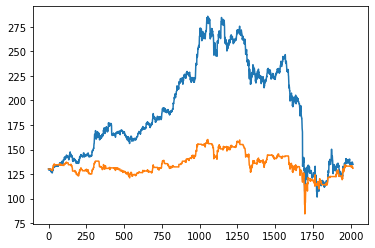

In [161]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

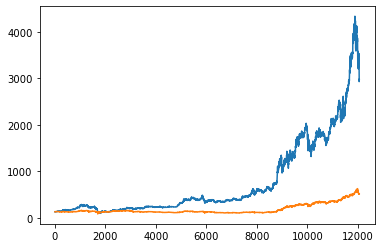

In [162]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

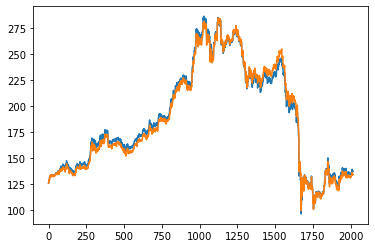

In [28]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

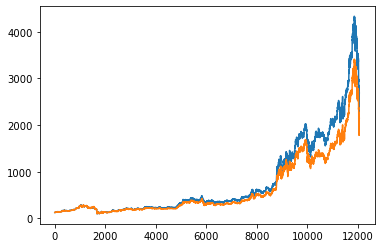

In [29]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

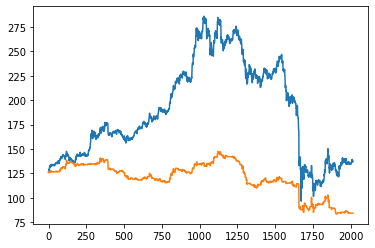

In [75]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

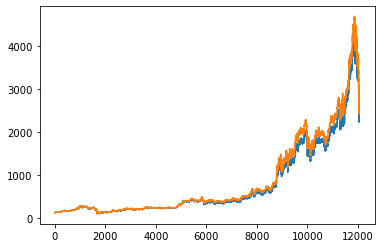

In [37]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

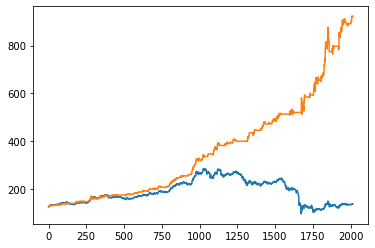

In [41]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


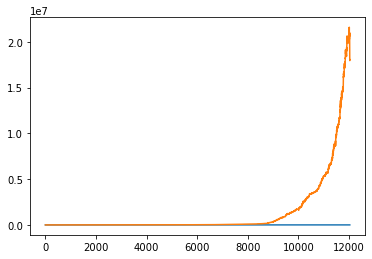

In [42]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

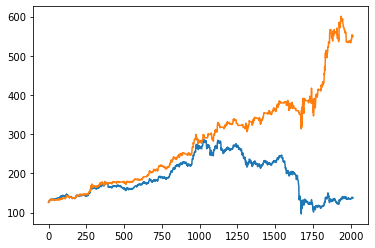

In [36]:
# PPO new
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


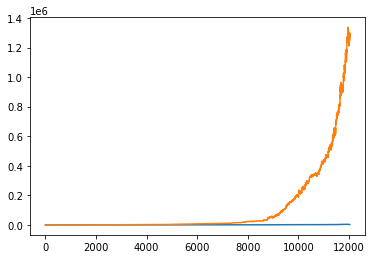

In [35]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


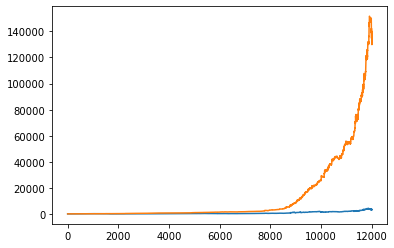

In [152]:
# PPO load
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

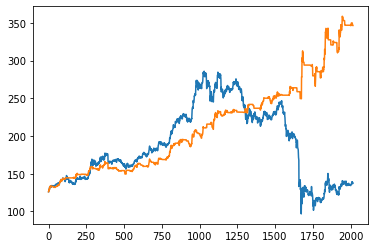

In [153]:
# PPO load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

<AxesSubplot:>

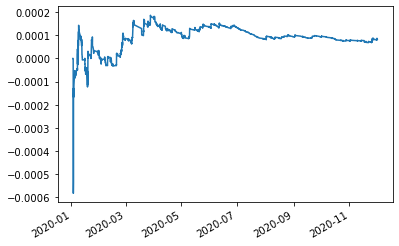

In [133]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

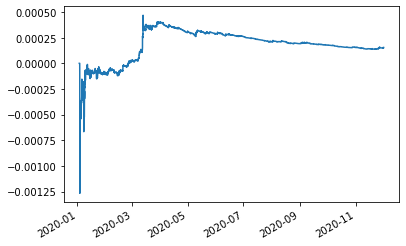

In [194]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

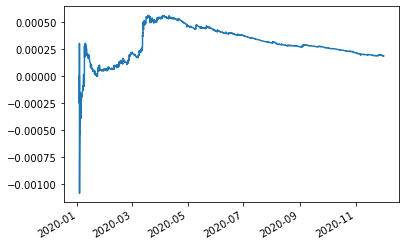

In [220]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

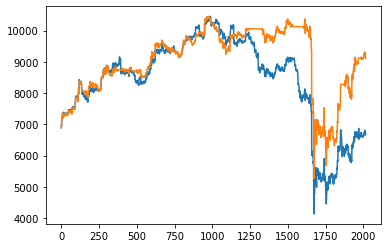

In [129]:
# DQN
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

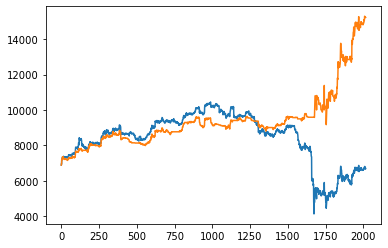

In [195]:
# PPO last
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

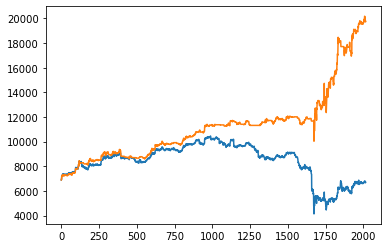

In [221]:
# PPO best
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

250K


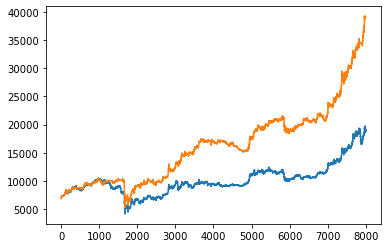

In [112]:
# DQN
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


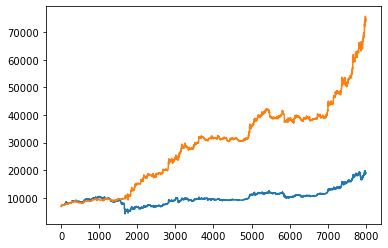

In [196]:
# PPO last
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


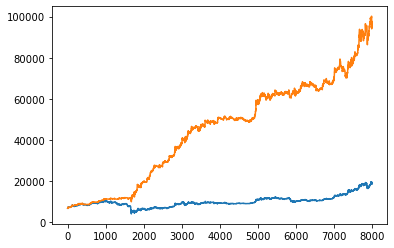

In [222]:
# PPO best
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

# Other

In [43]:
from scipy.optimize import brute, minimize
from sklearn.metrics import plot_roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Lasso,
    Ridge,
    ElasticNet,
    ARDRegression
)

from sklearn.neighbors import (
    KNeighborsClassifier,
    KNeighborsRegressor
)

from sklearn.neural_network import (
    MLPRegressor,
    MLPClassifier,
)

from sklearn.svm import (
    SVC,
    SVR,
)

from sklearn.gaussian_process import (
    GaussianProcessClassifier
)

from sklearn.ensemble import (
    VotingRegressor,
    StackingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    
    StackingClassifier,
    VotingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    
)

In [44]:
def sharpe(a):
    daily_returns = a.pct_change()
    return daily_returns.mean() / daily_returns.std()

def compute_gains(params, kline, transform=None, sharpen=True, return_backtest=False, **kwargs):
    if transform is None:
        transform = lambda x: np.mean(x, axis=1)
    default_kwargs = dict(start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
    kwargs = {**default_kwargs, **kwargs}
    btst = Backtest(kline, **kwargs)
    _signals = transform(kline.signals)[:-1]
    lower, upper = params
    signals = np.where(_signals < lower, -1, np.where(_signals >= upper, 1, 0))
    btst.run(9999*signals, verbose=0)
    if return_backtest:
        return btst
    if sharpen:
        return -sharpe(btst.periodic['value'])
    return -btst._periodic[btst.position['timestamp']]['value']

def maximize_gains(kline,
                   ranges=(slice(0, 1, .05), slice(0, 1, .05)),
                   transform=None,
                   sharpen=True,
                   limit=2880,
                   size=168,
                   episodes=10
                  ):
    result_dict = dict.fromkeys(range(episodes))
    for episode in range(episodes):
        while True:
            limited_index = kline.index[-limit:]
            random_index = limited_index[:np.random.randint(limited_index.size)][-size:]
            if random_index.size >= size:
                break
        if hasattr(transform, 'predict_proba'):
            mod = transform()
            mod.fit(y=kline.close.pct_change().shift(-1).lt(0).loc[random_index].ffill(),
                    X=kline.signals.loc[random_index].ffill())
            transform = lambda x: mod.predict_proba(x)[:, 0]
        elif hasattr(transform, 'predict'):
            mod = transform()
            mod.fit(y=kline.close.pct_change().shift(-1).loc[random_index].ffill(),
                    X=kline.signals.loc[random_index].ffill())
            transform = lambda x: mod.predict(x)
        best_params = brute(compute_gains, ranges=ranges, args=(kline.loc[random_index], transform, sharpen), disp=False)
        result_dict[episode] = best_params, transform
    result_df = pd.DataFrame([_[0] for _ in result_dict.values()]).sort_values([0, 1])
    # best_index = result_df.iloc[[result_df.shape[0]//2]].index[0]
    # return result_dict[best_index]
    best_params = tuple(pd.DataFrame([_[0] for _ in res.values()]).mean())
    if hasattr(transform, 'predict_proba'):
        mod = transform()
        mod.fit(y=kline.close.pct_change().shift(-1).lt(0).loc[limited_index].ffill(),
                X=kline.signals.loc[limited_index].ffill())
        transform = lambda x: mod.predict_proba(x)[:, 0]
    elif hasattr(transform, 'predict'):
        mod = transform()
        mod.fit(y=kline.close.pct_change().shift(-1).loc[limited_index].ffill(),
                X=kline.signals.loc[limited_index].ffill())
        transform = lambda x: mod.predict(x)
    return best_params, transform

In [45]:
kline = klmngr['ETHUSDT']

In [46]:
kline.signalsjar.flush()
kline.signalsjar.set_raw()

In [47]:
kline_binary = Kline('ETHUSDT', data=kline, info=kline.info)

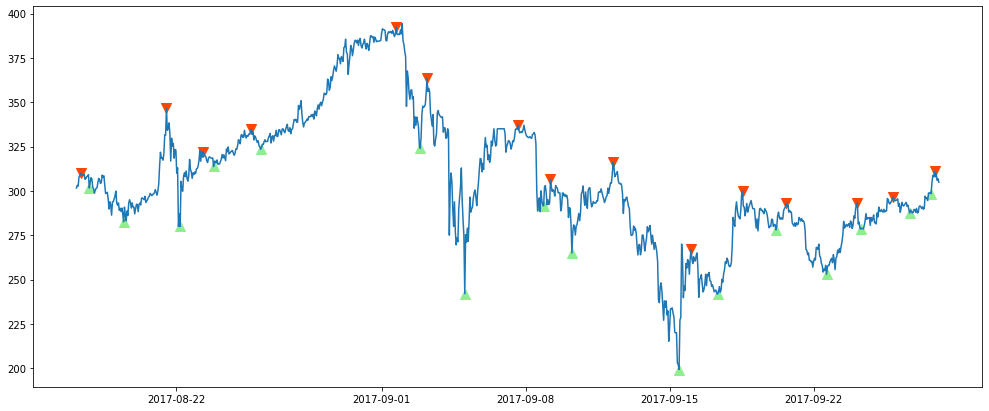

In [48]:
def compute_target(kline, window=10):
    close = kline.close
    close_rolled = close.rolling(24, center=True, min_periods=1).mean()
    close_rolled_pctchange = close_rolled.pct_change()
    close_rolled_pctchange_rolled = close_rolled_pctchange.rolling(window, center=True, min_periods=1).sum()
    enter = close_rolled_pctchange_rolled.shift(-1).gt(.0) & close_rolled_pctchange_rolled.shift(0).lt(.0)
    exit = close_rolled_pctchange_rolled.shift(-1).lt(.0) & close_rolled_pctchange_rolled.shift(0).gt(.0)
    enter_rolled = enter.shift(-window).rolling(window*2).max().astype(bool)
    enter_rolled_idxmin = close[enter_rolled].groupby(enter_rolled.diff().cumsum()).idxmin()
    enter_corrected = pd.Series(close.index.isin(enter_rolled_idxmin), index=close.index)
    exit_rolled = exit.shift(-window).rolling(window*2).max().astype(bool)
    exit_rolled_idxmax = close[exit_rolled].groupby(exit_rolled.diff().cumsum()).idxmax()
    exit_corrected = pd.Series(close.index.isin(exit_rolled_idxmax), index=close.index)
    position = enter_corrected.astype(int) + exit_corrected.astype(int).multiply(-1)
    return position

def plot_target(position, close, ax=None, plot_close=True, **kwargs):
    axx = plt if ax is None else ax
    if plot_close:
        axx.plot(close)
    axx.scatter(*close[position.eq(1)].T.to_frame().reset_index().T.values.tolist(), **{'c':'lightgreen', 'marker':'^', 's':100, **kwargs})
    axx.scatter(*close[position.eq(-1)].T.to_frame().reset_index().T.values.tolist(), **{'c':'orangered', 'marker':'v', 's':100, **kwargs})

def cut_probas(probas, smooth=5, threshold=.1, as_quantile=True):
    sell_sig = y_pred[:, 0]
    buy_sig = y_pred[:, -1]
    if smooth > 1:
        sell_sig = pd.Series(sell_sig).rolling(smooth).mean().fillna(0).values
        buy_sig = pd.Series(buy_sig).rolling(smooth).mean().fillna(0).values
    sell_thresh = buy_thresh = threshold
    if as_quantile:
        sell_thresh = np.quantile(sell_sig, 1-threshold)
        buy_thresh = np.quantile(buy_sig, 1-threshold)
    return ((sell_sig > sell_thresh) * -1) + (buy_sig > buy_thresh)

def interpret_probas_old(probas, smooth=2, repeat=5):
    sell_sig = y_pred[:, 0]
    buy_sig = y_pred[:, -1]
    sell_sig_smooth = pd.Series(sell_sig).rolling(smooth).mean()
    buy_sig_smooth = pd.Series(buy_sig).rolling(smooth).mean()
    sell = (
        (sell_sig_smooth.pct_change().rolling(repeat).sum().lt(0))
        &
        (sell_sig_smooth.pct_change().rolling(repeat).sum().shift(repeat).gt(0))
        &
        (sell_sig_smooth > buy_sig_smooth)
    ).astype(int).multiply(-1)
    buy = (
        (buy_sig_smooth.pct_change().rolling(repeat).sum().lt(0))
        &
        (buy_sig_smooth.pct_change().rolling(repeat).sum().shift(repeat).gt(0))
        &
        (buy_sig_smooth > sell_sig_smooth)
    ).astype(int)
    return sell + buy

def interpret_probas(probas, smooth=2, threshold=1):
    sell_sig = y_pred[:, 0]
    buy_sig = y_pred[:, -1]
    sell_sig_past = pd.Series(sell_sig).rolling(smooth).mean().shift(1)
    buy_sig_past = pd.Series(buy_sig).rolling(smooth).mean().shift(1)
    sell_sig_corrected = sell_sig / sell_sig_past
    buy_sig_corrected = buy_sig / buy_sig_past
    sell = (
        (sell_sig_corrected > threshold)
        &
        (sell_sig_corrected > buy_sig_corrected)
    ).astype(int).multiply(-1)
    buy = (
        (buy_sig_corrected > threshold)
        &
        (buy_sig_corrected > sell_sig_corrected)
    ).astype(int)
    return sell + buy
        
index = pd.IndexSlice[:1000]
fig, ax = plt.subplots(figsize=(17, 7))
plot_target(compute_target(kline[index]), kline[index].close, )

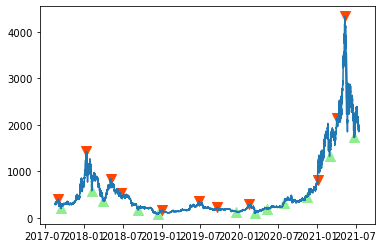

In [175]:
plot_target(compute_target(kline, window=500), kline.close, )

In [196]:
train_index = kline.index[:int(kline.shape[0]*.7)]
test_index = kline.index[int(kline.shape[0]*.7):]
y = compute_target(kline, window=250)
# y = kline.close.pct_change().shift(-1).fillna(0)
y_train = y[train_index]
y_test = y[test_index]
X_train = kline.signals.loc[train_index]
X_train = pd.concat([
    X_train,
#     kline.indicators.divide(kline.close.values, axis=0).loc[train_index]
    kline.loc[train_index, ['open', 'high', 'low', 'close']]
], axis=1)
X_test = kline.signals.loc[test_index]
X_test = pd.concat([
    X_test,
#     kline.indicators.divide(kline.close.values, axis=0).loc[test_index]
    kline.loc[test_index, ['open', 'high', 'low', 'close']]
], axis=1)
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

In [ ]:
kline_daily = kline.daily
train_index = kline_daily.index[:int(kline_daily.shape[0]*.7)]
test_index = kline_daily.index[int(kline_daily.shape[0]*.7):]
y = kline_daily.close.pct_change().shift(-1).fillna(0)
y_train = y[train_index]
y_test = y[test_index]
X_train = kline_daily.signals.loc[train_index]
X_train = pd.concat([
    X_train,
#     kline.indicators.divide(kline.close.values, axis=0).loc[train_index]
    kline_daily.loc[train_index, ['open', 'high', 'low', 'close']]
], axis=1)
X_test = kline_daily.signals.loc[test_index]
X_test = pd.concat([
    X_test,
#     kline.indicators.divide(kline.close.values, axis=0).loc[test_index]
    kline_daily.loc[test_index, ['open', 'high', 'low', 'close']]
], axis=1)
X_train = X_train.fillna(-1)
X_test = X_test.fillna(-1)

In [198]:
# mod = MLPRegressor((100, 100))
# mod = RandomForestClassifier()
mod = AdaBoostClassifier()

In [ ]:
mod = StackingRegressor([
    ('log', LinearRegression()),
    ('svc', SVR()),
    ('knn', KNeighborsRegressor()),
    ('ada', AdaBoostRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('rf', RandomForestRegressor()),
    ('xt', ExtraTreesRegressor()),
], final_estimator=LinearRegression())

In [ ]:
mod = VotingClassifier([
    ('log', LogisticRegression(solver='liblinear')),
    ('svc', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('rf', RandomForestClassifier()),
    ('xt', ExtraTreesClassifier()),
], voting='soft')

In [ ]:
mod = StackingClassifier([
    ('log', LogisticRegression(solver='liblinear')),
    ('svc', SVC(probability=True)),
    ('knn', KNeighborsClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('rf', RandomForestClassifier()),
    ('xt', ExtraTreesClassifier()),
], final_estimator=LogisticRegression(solver='liblinear'),)

In [200]:
mod.fit(y=y_train, X=X_train)

AdaBoostClassifier()

In [201]:
y_pred = mod.predict_proba(X_test)

In [ ]:
y_pred = mod.predict(X_test)

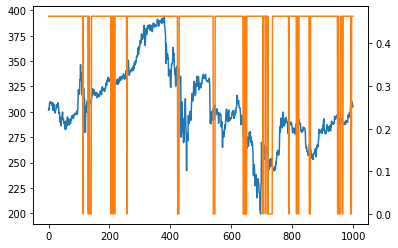

In [202]:
index = pd.IndexSlice[:1000]
fig, ax = plt.subplots()
ax2 = ax.twinx()
# plt.plot(y_test.values[index])
ax.plot(kline.close[index].values)
ax2.plot(y_pred[index, 0], c='C1')

In [ ]:
accuracy_score(np.sign(y_test[index]), np.sign(y_pred[index]))

In [ ]:
index = pd.IndexSlice[:100]
plt.plot(y_test.values[index])
plt.plot(y_pred[index])

In [ ]:
def interpret_pred(pred, threshold=.005, window=24):
    # pred_corrected = (pred-pd.Series(pred).rolling(window).mean().shift(1))
    pred_corrected = pred
    return np.where(pred_corrected > threshold, 1, np.where(pred_corrected < -threshold, -1, 0))

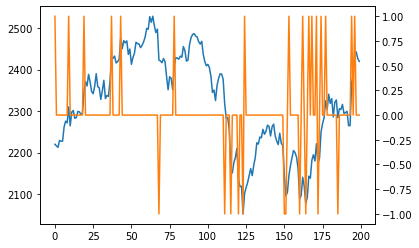

In [59]:
index = pd.IndexSlice[-2000:-1800]
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(kline.close[test_index][index].values)
ax2.plot(interpret_pred(y_pred[index], .01, window=1), c='C1')

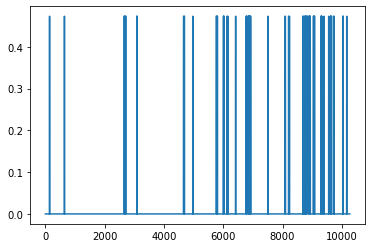

In [184]:
plt.plot(y_pred[:, 2])

In [188]:
index = pd.IndexSlice[-1000:]
plot_target(
#     pd.Series(cut_probas(y_pred, 5, .05, True), index=test_index)[index],
#     pd.Series(interpret_probas(y_pred, 10, 5).values, index=test_index)[index],
#     pd.Series(np.where(y_pred[:, 0] > .6, 1, np.where(y_pred[:, 0] < .6, -1, 0)), index=test_index)[index],
    kline.close[test_index][index]
)

TypeError: plot_target() missing 1 required positional argument: 'close'

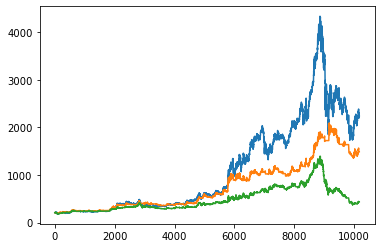

In [60]:
_sigs = kline_binary.loc[test_index].signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))
btst_ref = Backtest(kline_binary.loc[test_index], start_index=0, init_assets=1, commission=0.00, slippage_pct=0., slippage_steps=0)
btst_ref.run(999*sigs, verbose=0)

y_pred = mod.predict(X_test)
sigs = interpret_pred(y_pred, .01, window=24*7)[:-1]
# sigs = interpret_probas(y_pred, 10, 5).values[:-1]
# sigs = cut_probas(y_pred, .1)[:-1]
btst = Backtest(kline_binary.loc[test_index], start_index=0, init_assets=1, commission=0.00, slippage_pct=0., slippage_steps=0)
btst.run(999*sigs, verbose=0)

fig, ax = plt.subplots()
ax.plot(kline.loc[test_index].close.values)
ax.plot(btst_ref.periodic.value.values)
ax.plot(btst.periodic.value.values)

In [ ]:
i = 23488 + 5000 # 23488
index = kline.index[i]

_sigs = kline_binary[index:].signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))
btst_ref = Backtest(kline_binary[index:], start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst_ref.run(999*sigs, verbose=0)

best_params, transform = maximize_gains(kline[:index], transform=GradientBoostingClassifier, limit=24*30*6, size=24*30*6, episodes=1)
btst = compute_gains(best_params, kline[index:], transform=transform, return_backtest=True)

print(
    sharpe(btst_ref.periodic['value']),
    sharpe(btst.periodic['value'])
)

fig, ax = plt.subplots()
ax.plot(kline[index:].close.values)
ax.plot(btst_ref.periodic.value.values)
ax.plot(btst.periodic.value.values)

0.023674911599260703 0.005175152923631935


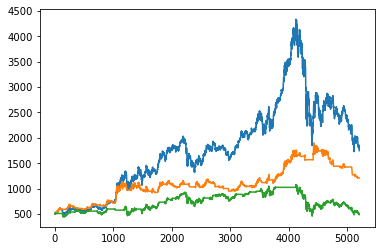

In [622]:
i = 23488 + 5000 # 23488
index = kline.index[i]

_sigs = kline_binary[index:].signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))
btst_ref = Backtest(kline_binary[index:], start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst_ref.run(999*sigs, verbose=0)

best_params, transform = maximize_gains(kline[:index], transform=GradientBoostingClassifier, limit=24*30*6, size=24*7*2)
btst = compute_gains(best_params, kline[index:], transform=transform, return_backtest=True)

print(
    sharpe(btst_ref.periodic['value']),
    sharpe(btst.periodic['value'])
)

fig, ax = plt.subplots()
ax.plot(kline[index:].close.values)
ax.plot(btst_ref.periodic.value.values)
ax.plot(btst.periodic.value.values)

Optimization terminated successfully.
         Current function value: -0.036814
         Iterations: 15
         Function evaluations: 41
0.02789647638910845 0.036813570310926635


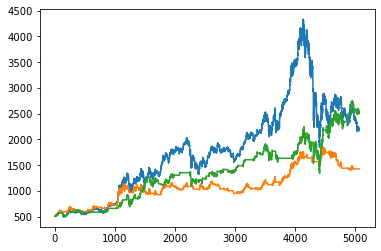

In [1001]:
i = 23488 + 5000 # 23488
index = kline.index[i]

_sigs = kline_binary[index:].signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))
btst_ref = Backtest(kline_binary[index:], start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst_ref.run(999*sigs, verbose=0)

best_params, transform = maximize_gains(kline[index:], limit=None, transform=GradientBoostingClassifier, sharpen=True)
btst = compute_gains(best_params, kline[index:], transform=transform, return_backtest=True)

print(
    sharpe(btst_ref.periodic['value']),
    sharpe(btst.periodic['value'])
)

fig, ax = plt.subplots()
ax.plot(kline[index:].close.values)
ax.plot(btst_ref.periodic.value.values)
ax.plot(btst.periodic.value.values)

Optimization terminated successfully.
         Current function value: -1311.277380
         Iterations: 9
         Function evaluations: 33
0.01813356654334556 0.02177811343060684


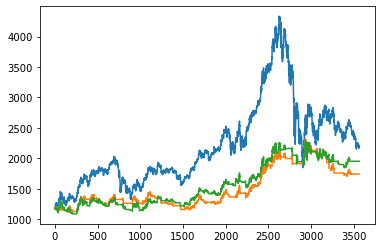

In [1015]:
i = 23488 + 6500 # 23488
index = kline.index[i]

_sigs = kline_binary[index:].signals.eq(1).mean(axis=1).rolling(3).median().values[:-1]
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))
btst_ref = Backtest(kline_binary[index:], start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst_ref.run(999*sigs, verbose=0)

best_params, transform = maximize_gains(kline[:index], limit=24*14, transform=None, sharpen=False)
btst = compute_gains(best_params, kline[index:], transform=transform, return_backtest=True)

print(
    sharpe(btst_ref.periodic['value']),
    sharpe(btst.periodic['value'])
)

fig, ax = plt.subplots()
ax.plot(kline[index:].close.values)
ax.plot(btst_ref.periodic.value.values)
ax.plot(btst.periodic.value.values)

In [845]:
for i in np.linspace(0, kline.index.shape, 10).astype(int)[1:]:
    index = kline.index[i]
    kline_part = kline.loc[index]
    maximize_gains(kline_part)

array([[ 3728],
       [ 7456],
       [11185],
       [14913],
       [18641],
       [22370],
       [26098],
       [29826],
       [33555]])

In [209]:
kline = klmngr['ETHUSDT']

In [210]:
index_split = kline.index[int(kline.index.shape[0] * 0.7)]

In [278]:
# y_train = kline.close.shift(-1).loc[:index_split]
# y_train = kline.close.pct_change().shift(-1).loc[:index_split]
y_train = kline.close.pct_change().shift(-1).loc[:index_split]
y_test = kline.close.pct_change().shift(-1).loc[index_split:]

In [279]:
X_train = kline.signals.loc[:index_split]
X_test = kline.signals.loc[index_split:]

In [280]:
X_train = X_train.bfill()
X_test = X_test.bfill()

In [434]:
mod = VotingRegressor([
    ('lr', LinearRegression()),
    ('bayes', BayesianRidge(normalize=True)),
    ('ada', AdaBoostRegressor(loss='linear')),
    ('gb', GradientBoostingRegressor(loss='lad')),
    ('rf', RandomForestRegressor()),
    ('xt', ExtraTreesRegressor()),
#     ('mlp', MLPRegressor(200, alpha=0.01, early_stopping=True)),
])

In [ ]:
mod = RandomForestRegressor()
# mod = GradientBoostingClassifier()

In [435]:
mod.fit(X=X_train, y=y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('bayes', BayesianRidge(normalize=True)),
                            ('ada', AdaBoostRegressor()),
                            ('gb', GradientBoostingRegressor(loss='lad')),
                            ('rf', RandomForestRegressor()),
                            ('xt', ExtraTreesRegressor())])

In [ ]:
y_pred_all = mod.transform(X_test)

In [ ]:
plt.plot(y_test.values)
plt.plot(y_pred_all[:, 2], alpha=.5)

In [437]:
y_pred = mod.predict(X_test)
# y_probas = mod.predict_proba(X_test)

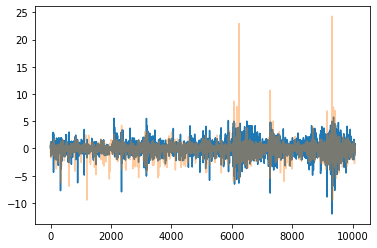

In [460]:
fig, ax = plt.subplots()
ax.plot(StandardScaler().fit_transform(y_test.values.reshape(-1, 1)))
ax.plot(StandardScaler().fit_transform(y_pred.reshape(-1, 1)), alpha=.4)
# ax.set_ylim(-.5, .5)

In [118]:
roc_auc_score(y_pred, y_test), accuracy_score(y_pred, y_test)

(0.539233378061254, 0.5409754643885964)

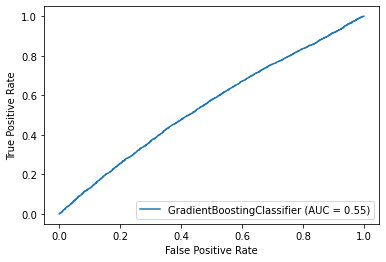

In [127]:
plot_roc_curve(mod, X_test, y_test)

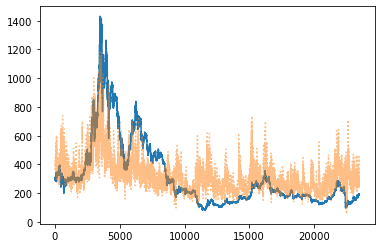

In [74]:
plt.plot(y_train.values)
plt.plot(y_pred, alpha=.5, linestyle=':')

-0.006999999999999999 0.003


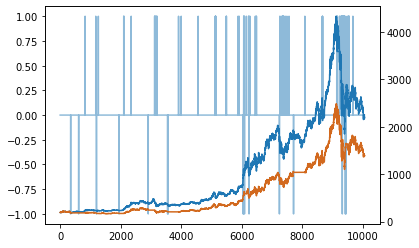

In [590]:
_sigs = y_pred[:-1] #y_probas[:-1, 0]
center = 0
delta = .005
skew = .4
lower = center-delta*(1+skew)
upper = center+delta*(1-skew)
print(lower, upper)
sigs = np.where(_sigs < lower, -1, np.where(_sigs >= upper, 1, 0))

btst = Backtest(kline.loc[index_split:], start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline.loc[index_split:].close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')

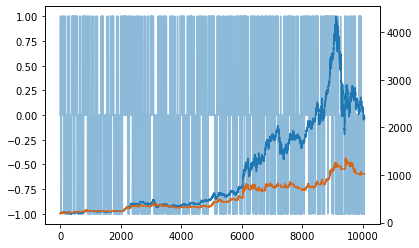

In [558]:
fig, ax = plt.subplots()
ax.plot(sigs, alpha=.5)
ax2 = ax.twinx()
ax2.plot(kline_part.close.values)
ax2.plot(btst.periodic.value.values, c='chocolate')